## Tutorial for using SMOPCA on Spatial-CITE-seq Human Tonsil dataset
Import modules.

In [4]:
import logging
import h5py
import numpy as np
import pandas as pd
import scanpy as sc
import warnings
from SMOPCA.model import SMOPCA
from sklearn.cluster import KMeans

for handler in logging.root.handlers[:]:  # avoid DEBUG level information in jupyter notebook
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO)  # use DEBUG for verbose information
warnings.filterwarnings('ignore')


Load and check dataset.

In [5]:
data_file = h5py.File("/nfs/public/chenmo/PCA/SMOPCA-v2/data/RealData/SpatialCITEseq/Humantonsil_filtered.h5", 'r')
X1 = np.array(data_file['normalized_svg_count'])
X2 = np.array(data_file['normalized_protein_count'])
pos = np.array(data_file['pos'])
data_file.close()
print(X1.shape, X2.shape, pos.shape)

(2491, 959) (2491, 283) (2491, 2)


Build the SMOPCA model and inference parameters.

In [6]:
smopca = SMOPCA(Y_list=[X1.T, X2.T], Z_dim=20, pos=pos, intercept=False, omics_weight=False)
smopca.estimateParams(sigma_init_list=(1, 1), tol_sigma=2e-5, sigma_xtol_list=(1e-6, 1e-6), gamma_init=1, estimate_gamma=True)
z = smopca.calculatePosterior()
y_pred = KMeans(n_clusters=7, n_init=100).fit_predict(z)

INFO:SMOPCA.model:SMOPCA object created, with 2491 cells and [959, 283] features and matern kernel
INFO:SMOPCA.model:start estimating parameters, this will take a while...
INFO:SMOPCA.model:calculating matern kernel, nu = 1.5, length_scale = 1
INFO:SMOPCA.model:estimating sigma1
INFO:SMOPCA.model:sigma1 using bound: (0.90000, 1.00000)
INFO:SMOPCA.model:iter 0 sigma1 brentq done, sigma1sqr = 1.00000, sigma1hatsqr = 0.95174
INFO:SMOPCA.model:iter 1 sigma1 brentq done, sigma1sqr = 0.95174, sigma1hatsqr = 0.95171
INFO:SMOPCA.model:iter 2 sigma1 brentq done, sigma1sqr = 0.95171, sigma1hatsqr = 0.95171
INFO:SMOPCA.model:reach tolerance threshold, sigma1 done!
INFO:SMOPCA.model:estimating sigma2
INFO:SMOPCA.model:sigma2 using bound: (0.70000, 0.80000)
INFO:SMOPCA.model:iter 0 sigma2 brentq done, sigma2sqr = 1.00000, sigma2hatsqr = 0.78589
INFO:SMOPCA.model:iter 1 sigma2 brentq done, sigma2sqr = 0.78589, sigma2hatsqr = 0.78569
INFO:SMOPCA.model:iter 2 sigma2 brentq done, sigma2sqr = 0.78569, s

Visualize the inferred spatial domain.

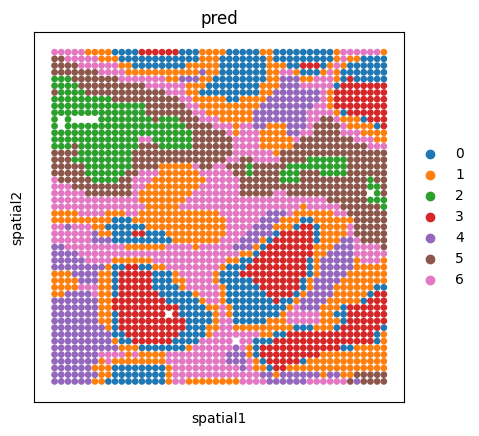

In [7]:
adata_res = sc.AnnData(z)
adata_res.obsm['spatial'] = pos
adata_res.obs['pred'] = pd.Categorical(y_pred)
sc.pl.spatial(adata_res, color='pred', spot_size=1)

Visualize the latent space using UMAP.

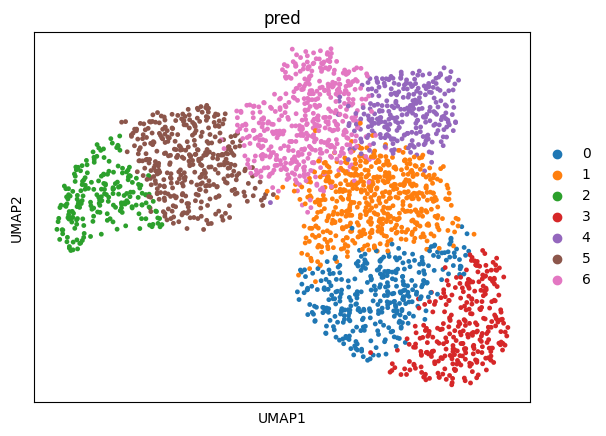

In [13]:
sc.pp.neighbors(adata_res, n_neighbors=100, use_rep='X', metric='euclidean')
sc.pl.umap(adata_res, color='pred')
sc.tl.umap(adata_res, min_dist=1)

## Perform Differential Expression Analysis
Find marker genes and proteins for each cluster using FindMarkers.

In [ ]:
library(rhdf5)
library(dplyr)
library(Seurat)
library(Matrix)
library(patchwork)
for (feat_type in c('gene', 'protein')) {
    h5_file <- H5Fopen(paste0("./data/Humantonsil_filtered.h5"))
    cell <- as.matrix(h5_file$cell)  # 2491
    if (feat_type == 'gene') {
        X <- as(h5_file$raw_gene_count, "sparseMatrix")
        gene <- as.matrix(h5_file$gene)
        rownames(X) <- gene
    } else {
        X <- as(h5_file$raw_protein_count, "sparseMatrix")
        protein <- as.matrix(h5_file$protein)
        rownames(X) <- protein
    }
    h5closeAll()
    colnames(X) <- cell
    y_pred <- as.matrix(read.csv("./data/smopca_pred_label.csv", row.names=1))
    seu <- CreateSeuratObject(counts = X, project = "diff_expr", min.cells = 0, min.features = 0)
    seu <- NormalizeData(seu, normalization.method = "LogNormalize", scale.factor = 10000)
    Idents(seu) <- y_pred
    y_unique <- c('0', '1', '2', '3', '4', '5', '6')
    res_folder <- "./res/" 
    for (g in y_unique) {
        de.markers <- FindMarkers(seu, ident.1 = g, ident.2 = NULL, only.pos = F)
        write.csv(de.markers, file=paste0(res_folder, paste0("cluster-", g, "-de-", feat_type, ".csv")))
    }
}


Select marker genes and proteins and perpare expression data for visualization.

In [3]:
import numpy as np
import pandas as pd

top_feat_num = 10  # top gene num of each cluster
cluster_list = [0, 1, 2, 3, 4, 5, 6]
y_pred = pd.read_csv("./data/smopca_pred_label.csv", index_col=0).values.flatten()

for feat_type in ['gene', 'protein']:
    de_csv_list = []
    cluster_gene_dict = {}
    top_gene_list = []
    all_top_gene_list = []
    normed_df = pd.read_csv(f"./data/normed_{feat_type}_mat.csv", index_col=0)  # heatmap needs normalized raw data
    # print("checking raw data shape:", normed_df.shape, y_pred.shape)

    # find markers for each cluster
    for i in cluster_list:
        de_csv_i = pd.read_csv(f"./res/cluster-{i}-de-{feat_type}.csv", index_col=0)  # print this to see the sorted p values and genes
        # all_top_gene_list += list(de_csv_i.index[de_csv_i['p_val_adj'] < 0.05])
        # continue
        de_csv_list.append(de_csv_i)
        count = j = 0  # j for the current gene index
        while count < top_feat_num:
            if de_csv_i.index[j] in top_gene_list:
                # print(f"gene {de_csv_i.index[j]} already exist in {top_gene_list}, continue")
                j += 1
                continue
            if de_csv_i['p_val_adj'].iloc[j] > 0.05:
                # print(f"gene {de_csv_i.index[j]} p_val > 0.05, stop finding")
                break
            top_gene_list.append(de_csv_i.index[j])
            count += 1
            j += 1
        # print("cluster", i, de_csv_i.iloc[:j], end='\n\n')

    # find the subset expr matrix of interest
    data_list = []
    for top_gene in top_gene_list:
        expr_cluster_list = []
        expr_dat = np.array(normed_df.loc[top_gene])
        for i in cluster_list:
            expr_cluster = expr_dat[y_pred == i]
            expr_cluster_list.append(np.mean(expr_cluster))
        data_list.append(expr_cluster_list)
    data_mat = np.array(data_list)
    # print(data_mat.shape)
    data_df = pd.DataFrame(data=data_mat, index=top_gene_list, columns=[f'cluster_{i}' for i in cluster_list])
    # data_df = pd.DataFrame(data=data_mat.T, columns=top_gene_list, index=[f'cluster_{i}' for i in cluster_list])

    # change gene and protein names for plotting
    if feat_type == 'gene':
        new_ind = []
        for gene_name in data_df.index:
            if gene_name.count('.') == 0:
                new_ind.append(gene_name)
            else:
                new_gene_name = gene_name.replace('.', '-')
                new_ind.append(new_gene_name)
        data_df.index = new_ind
    elif feat_type == 'protein':
        new_ind = []
        for protein_name in data_df.index:
            if protein_name.count('human-mouse.Mac.2..Galectin.3') == 1:
                new_ind.append('Mac2')
            else:
                # new_ind.append(protein_name)
                new_ind.append(protein_name.split('.')[0])
        data_df.index = new_ind
    print(data_df)
    data_df.to_csv(f"./res/{feat_type}_dat_top={top_feat_num}.csv")

              cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  \
MSLN           0.863116   0.348343   0.316179   0.298636   0.434860   
S100A9         1.826826   1.192263   1.247720   1.188986   1.419395   
CLDN4          1.021964   0.567757   0.552269   0.550544   0.946062   
RNA28S5        4.768323   4.903660   4.944565   4.933288   4.705133   
SFN            1.254319   0.695050   0.853502   0.848174   0.905601   
LTF            2.680746   2.342450   2.406904   2.402208   2.410708   
IGHG2          5.245831   5.233801   5.087834   5.081243   5.101277   
IGHG4          5.032928   5.025676   4.879693   4.854009   4.880756   
IGHG3          5.128802   5.143990   4.971307   4.985916   4.942214   
ACTB           3.679032   3.777399   3.832767   3.861444   3.606470   
IGHA1          4.068437   4.103283   3.929537   3.902507   3.937191   
RNA18S5        3.721588   4.015489   3.889107   3.953035   3.060452   
IGHA2          3.528805   3.535386   3.407750   3.310199   3.398763   
ADAM15

Visualize the marker genes and proteins with heatmap.

Warning message:
"package 'pheatmap' was built under R version 4.3.2"


         MSLN      S100A9      CLDN4    RNA28S5         SFN         LTF
0  2.20998069  2.09142808  1.6308973 -1.0783941  2.10287896  2.19501385
1 -0.32627433 -0.72417619 -0.4996964  0.3570558 -1.12825859 -0.65873959
2 -0.48474752 -0.47811030 -0.5723490  0.7909096 -0.21281203 -0.11503115
3 -0.57118052 -0.73871894 -0.5804384  0.6713018 -0.24359708 -0.15464105
4  0.09998979  0.28362540  1.2748557 -1.7486105  0.08818532 -0.08294081
5 -0.52684548  0.05916438 -0.7143448  0.6882420 -0.23736110 -0.55045305
6 -0.40092263 -0.49321243 -0.5389244  0.3194954 -0.36903549 -0.63320819
       IGHG2      IGHG4       IGHG3        ACTB      IGHA1    RNA18S5
0  1.5178751  1.4720752  1.25914113 -1.00794564  1.2130165 -0.2522528
1  1.3480885  1.3727158  1.45515134 -0.01328565  1.6565335  0.5960264
2 -0.7119915 -0.6273548 -0.77343438  0.54657205 -0.5548762  0.2312537
3 -0.8050190 -0.9792456 -0.58489116  0.83654459 -0.8989031  0.4157681
4 -0.5222685 -0.6127898 -1.14890135 -1.74166271 -0.4574494 -2.1604707
5 -0

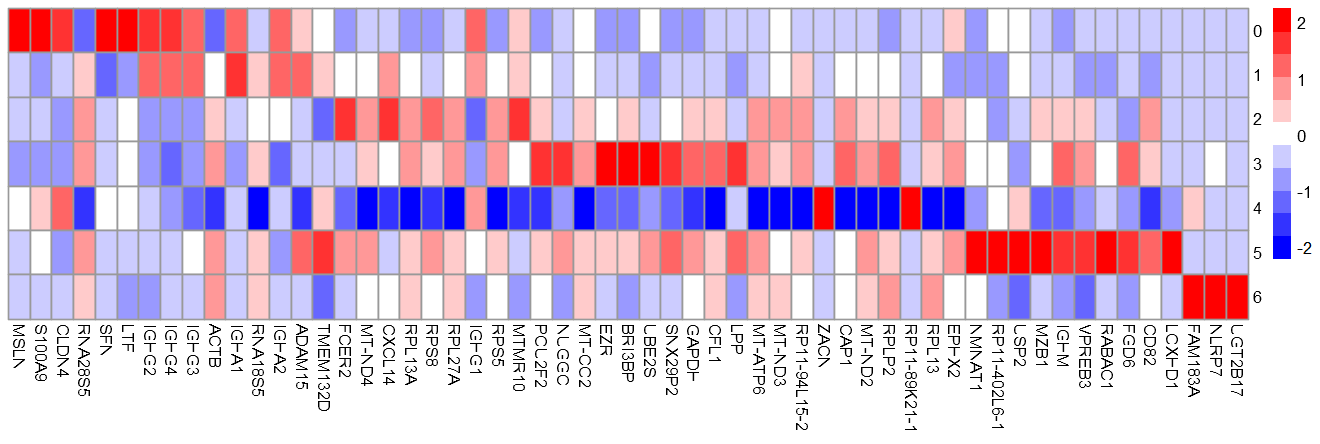

In [1]:
library(pheatmap)
myplot <- function(
	dat, ann, ann_color=NA, n.col=11, c_col=T, c_row=F, show_rownames=T, show_colnames=T, 
	breaks=seq(from=-max(abs(dat)), to=max(abs(dat)), len=n.col + 1), fontsize = 10
) {
	print(dat)
	pheatmap(
		dat, color = colorRampPalette(c("blue", "white", "red"))(n.col), clustering_distance_rows = "correlation",  clustering_distance_cols = "correlation",  clustering_method = "complete",
		cluster_cols = c_col, cluster_rows = c_row, fontsize = fontsize
	)
}

top_gene_num = 10
feat_type = 'gene'
dat_ = read.csv(paste0("./res/", feat_type, "_dat_top=", top_gene_num, ".csv"), row.names=1)
dat_ = t(scale(t(dat_), center = TRUE, scale = TRUE))
dat_[dat_ > 4] = 4
dat_[dat_ < -4] = -4

colnames(dat_)=c("0","1","2","3","4","5","6")

fontsize = 10
#pdf(paste0("./fig/", feat_type, "_fontsize=", fontsize, "_top=", top_gene_num, ".pdf"),width=11, height=3.7)
options(repr.plot.width=11,repr.plot.height=3.7)
myplot(t(dat_), ann=NA, ann_color=NA, c_col=F, c_row=F, show_colnames=F, show_rownames=T, fontsize=fontsize)#, breaks=break_ )
#dev.off()
tt=t(dat_)


       CD324      CD340       Mac2         EGFR        CD9      CD106
0  1.9023937  1.4999274  1.2637072  2.168084502  1.1682222 -0.9057214
1 -0.5458956 -0.4521462 -0.1386707 -0.283907868 -0.5073503 -0.5055411
2 -0.4408034 -0.3950600 -0.7031547 -0.080497062 -0.9394413  0.1209401
3 -0.5403537 -0.6818630 -0.7706833 -0.565552812 -0.2029901  1.0156666
4  0.8882555  1.3778273  1.5877790 -0.003450783  1.1780768 -1.1025606
5 -0.6998802 -0.9160945 -0.6780559 -0.872535818  0.6066405  1.6143213
6 -0.5637164 -0.4325910 -0.5609216 -0.362140159 -1.3031578 -0.2371050
       CD321       CD81       CD49b       CD35      CD49a        CD90
0  1.1723642 -0.9297801  1.52627553 -0.8899847 -0.5022813 -0.47712093
1 -1.0008691 -0.1124389 -0.01989476 -0.5707489  1.4074059  1.09428377
2 -0.9532753  0.1333726 -0.36844805  0.3861866  0.5757963  0.55488156
3 -0.2396065  0.9938167 -1.00600414  1.2784865 -0.7689303 -0.52553780
4  1.2680016 -1.3828107  1.23070915 -0.9836093 -0.8929792 -0.08264936
5  0.5906395  1.4744

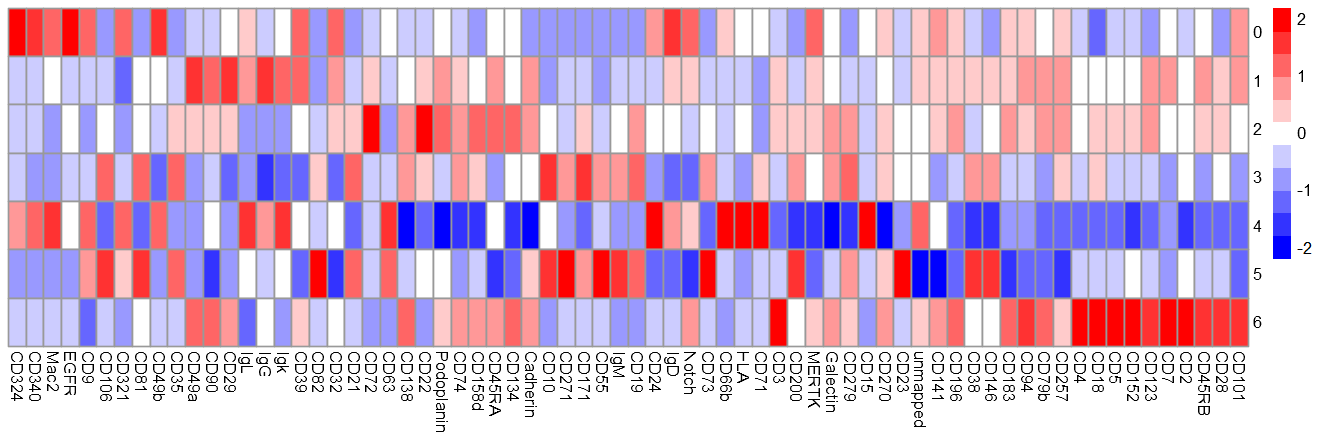

In [2]:
feat_type = 'protein'
dat_ = read.csv(paste0("./res/", feat_type, "_dat_top=", top_gene_num, ".csv"), row.names=1)
dat_ = t(scale(t(dat_), center = TRUE, scale = TRUE))
dat_[dat_ > 4] = 4
dat_[dat_ < -4] = -4

colnames(dat_)=c("0","1","2","3","4","5","6")

fontsize = 10
#pdf(paste0("./fig/", feat_type, "_fontsize=", fontsize, "_top=", top_gene_num, ".pdf"),width=11, height=3.7)
options(repr.plot.width=11,repr.plot.height=3.7)
myplot(t(dat_), ann=NA, ann_color=NA, c_col=F, c_row=F, show_colnames=F, show_rownames=T, fontsize=fontsize)#, breaks=break_ )
#dev.off()
tt=t(dat_)


Visualzie the spatial expression distribution of selected proteins.

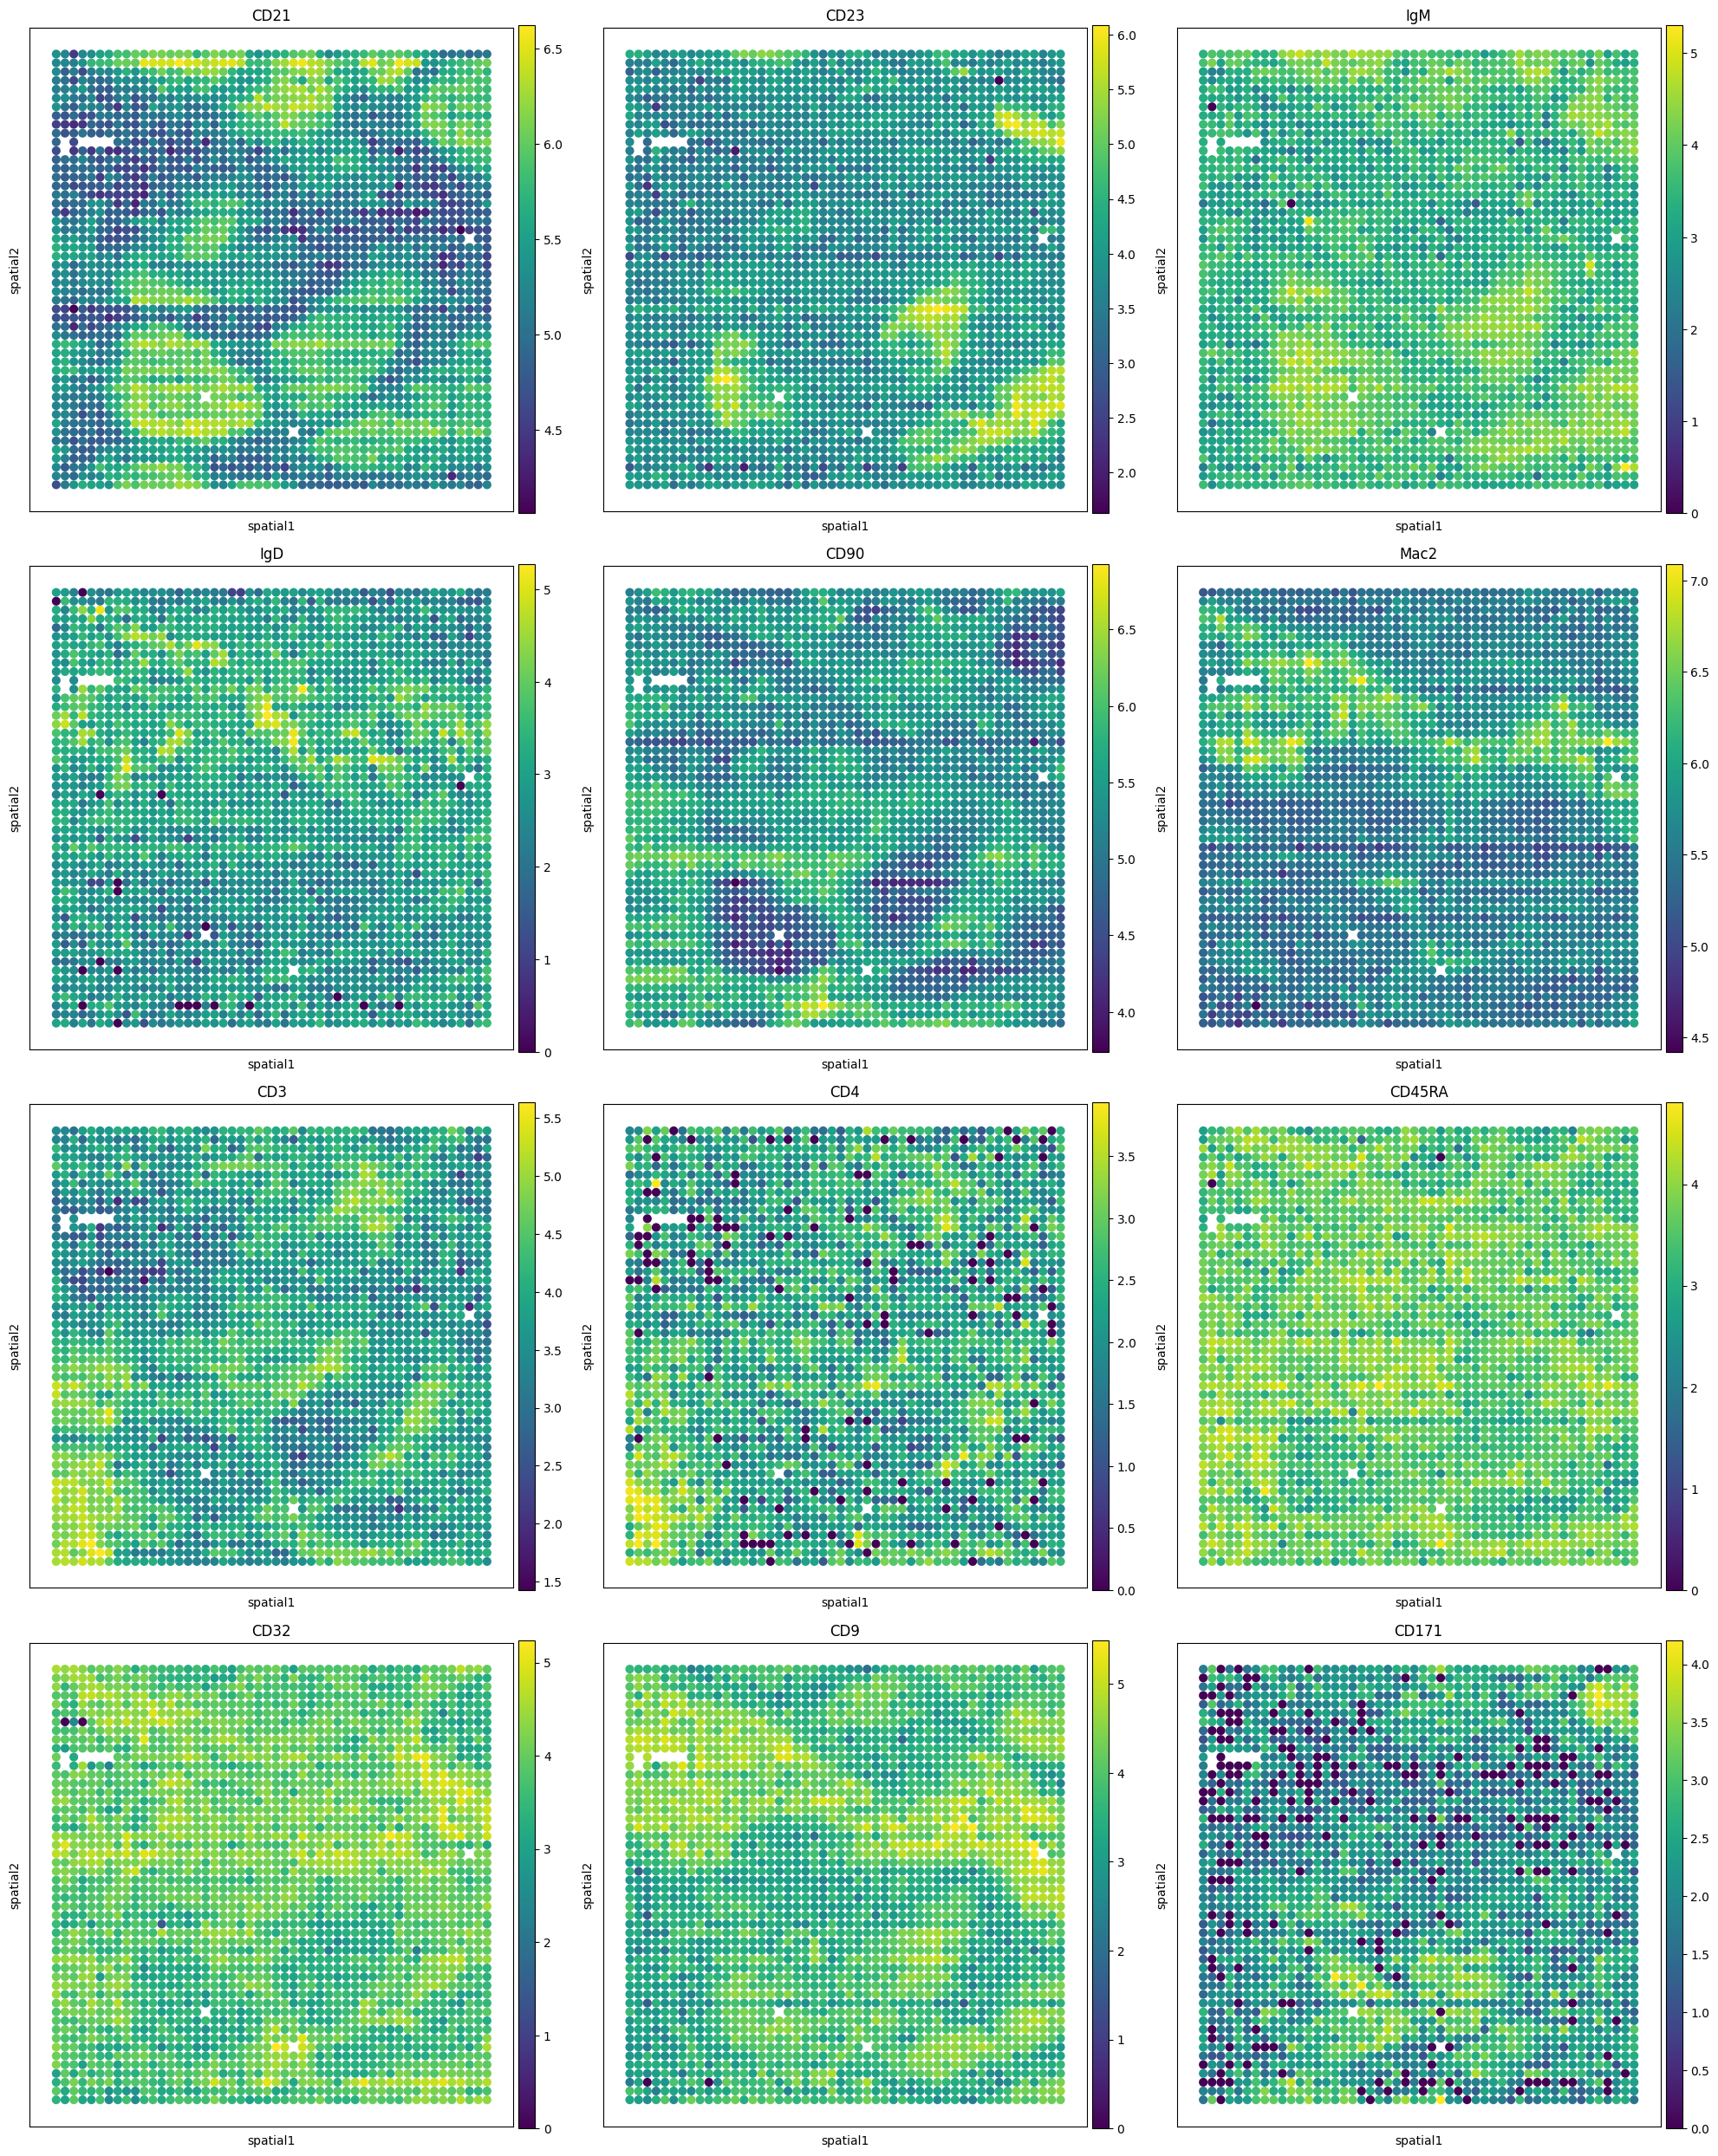

In [23]:
data_file = h5py.File("./data/Humantonsil_filtered.h5", 'r')
X = np.array(data_file['raw_protein_count'])
protein = np.array(data_file['protein']).astype(str)
pos = np.array(data_file['pos'])
data_file.close()
protein_rename = []
for name in protein:
    if name.count('Mac.2') == 1:
        protein_rename.append('Mac2')
    else:
        protein_rename.append(name.split('.')[0])
protein_rename = np.array(protein_rename)
plot_proteins = ['CD21', 'CD23', 'IgM', 'IgD', 'CD90', 'Mac2', 'CD3', 'CD4', 'CD45RA', 'CD32', 'CD9', 'CD171']
adata = sc.AnnData(X)
adata.obsm['spatial'] = pos
adata.var_names = protein_rename
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
fig, axes = plt.subplots(4, 3, figsize=(20, 25))
axes = axes.flatten()
for i, protein in enumerate(plot_proteins):
    sc.pl.spatial(adata, color=protein, ax=axes[i], show=False, title=protein, spot_size=1)
plt.tight_layout()
plt.show()

## Perform Gene Set Enrichement Analysis
Prepare data.

In [ ]:
library(fgsea)
library(Seurat)
library (dplyr)
library(tibble)
library(GSA)
library(ggplot2)
library(stringr)

colors <- c("red","orange","yellow", "green", "cyan", "blue","purple","deeppink")

gmt.file1 <- GSA::GSA.read.gmt("./data/c8.all.v2024.1.Hs.symbols.gmt")
gmt.file2<- GSA::GSA.read.gmt("./data/c2.cgp.v2024.1.Hs.symbols.gmt")
gmt.file3 <- GSA::GSA.read.gmt("./data/c6.all.v2024.1.Hs.symbols.gmt")

Fgsea=list()
name=list()
for(i in 1:7){
de <- read.csv(paste0("./res/cluster-", as.character(i-1), "-de-gene.csv"))

# sort genes with logFC
colnames(de)[colnames(de) == "X"] <- "genes"
cluster0.genes<- de %>% arrange(desc(avg_log2FC)) %>% dplyr::select(genes,avg_log2FC)

gmt.file=gmt.file1
if(i==3){
    gmt.file=gmt.file2
}    
if(i==6){
    gmt.file=gmt.file3
}     

ranks<- deframe(cluster0.genes)
pathways=gmt.file$genesets
names(pathways)=gmt.file$geneset.names

fgseaRes <- fgsea(pathways, ranks, minSize=15, maxSize=500)


half<-function(x){
  n=27
  string_length <- nchar(x)
  if(string_length<n+5){
    return(x)
  }
  if(string_length>2*n){
    third_length=floor(string_length / 3)
    first_half <- substr(x, 1, n)
    if(substr(first_half, n, n)=="_"){
      first_half=substr(first_half, 1, n-1)
    }
    second_half<-substr(x, n+1, 2*n-1)
    if(substr(second_half, 1, 1)=="_"){
      second_half=substr(second_half, 2, n-1)
    }
    if(substr(second_half, n-1, n-1)=="_"){
      second_half=substr(second_half, 1, n-2)
    }
    #third_half<-substr(x, 80+1, string_length)
    return(paste(first_half,second_half,sep="\n"))
  }
  half_length <- floor(string_length / 2)
  
  first_half <- substr(x, 1, n)
  if(substr(first_half, n, n)=="_"){
    first_half=substr(first_half, 1, n-1)
  }

  second_half<-substr(x, n+1, string_length)
  if(substr(second_half, 1, 1)=="_"){
    second_half=substr(second_half, 2, n-1)
  }
  if(substr(second_half, n, n)=="_"){
    second_half=substr(second_half, 1, n-2)
  }
  return(paste(first_half,second_half,sep="\n"))
}
#fgsea=fgseaRes %>% as_tibble() %>% arrange(desc(padj)) %>% filter(padj < 0.05)
#fgsea$leadingEdge<-NULL
#res_folder="./res/"
#feat_type="gene"
#write.csv(fgsea, file=paste0(res_folder, paste(feat_type,"_Cluster_", i, ".csv", sep = "")))

fgsea=fgseaRes %>% as_tibble() %>% arrange(desc(padj)) %>% filter(padj < 0.05) %>% head(n= 10)
Fgsea[i]=list(fgsea$padj)  
name[i]=list(sapply(fgsea$pathway,function(x) half(x)))
}


Visualize results for each cluster.

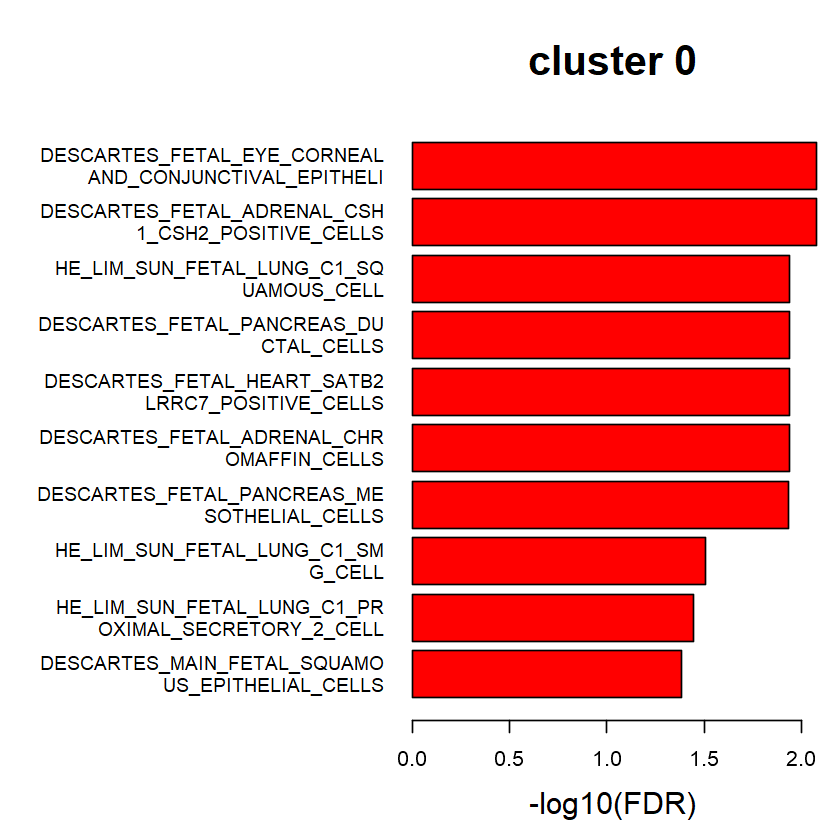

In [4]:
i=1
par(mar=c(5,17,5,1),fig=c(0,1,0,1))
barplot(-log10(unlist(Fgsea[i])),names=unlist(name[i]),col=colors[i],horiz = TRUE,las=1,xlab="-log10(FDR)",main=paste0("cluster ",as.character(i-1)),cex.names=0.92,cex.main=2,cex.lab=1.5)

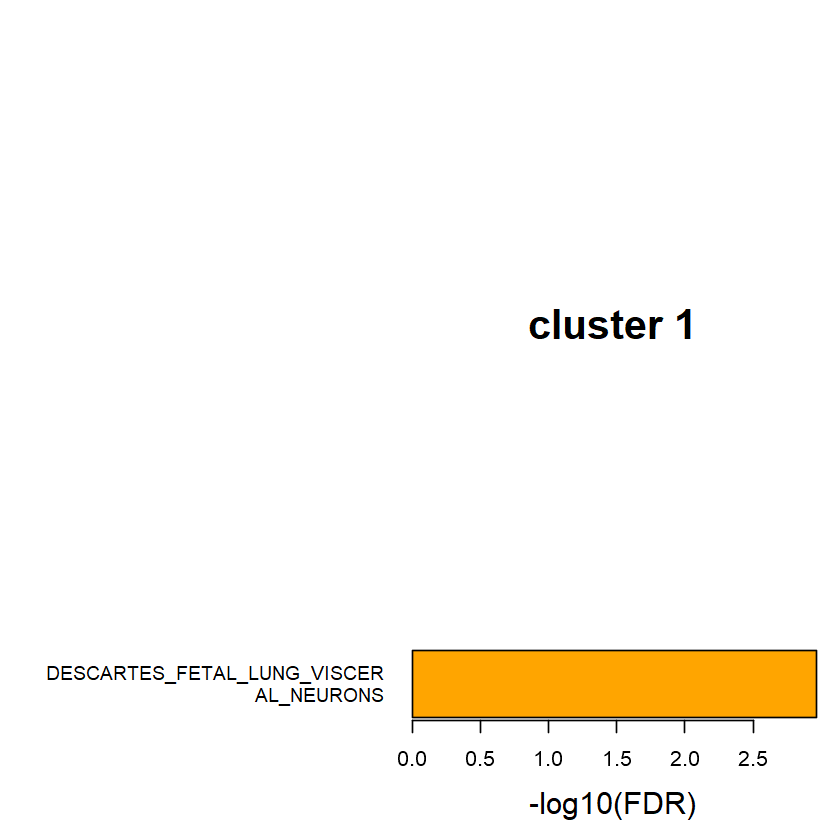

In [5]:
i=2
par(mar=c(5,17,27,1),fig=c(0,1,0,1))
barplot(-log10(unlist(Fgsea[i])),names=unlist(name[i]),col=colors[i],horiz = TRUE,las=1,xlab="-log10(FDR)",main=paste0("cluster ",as.character(i-1)),cex.names=0.92,cex.main=2,cex.lab=1.5)

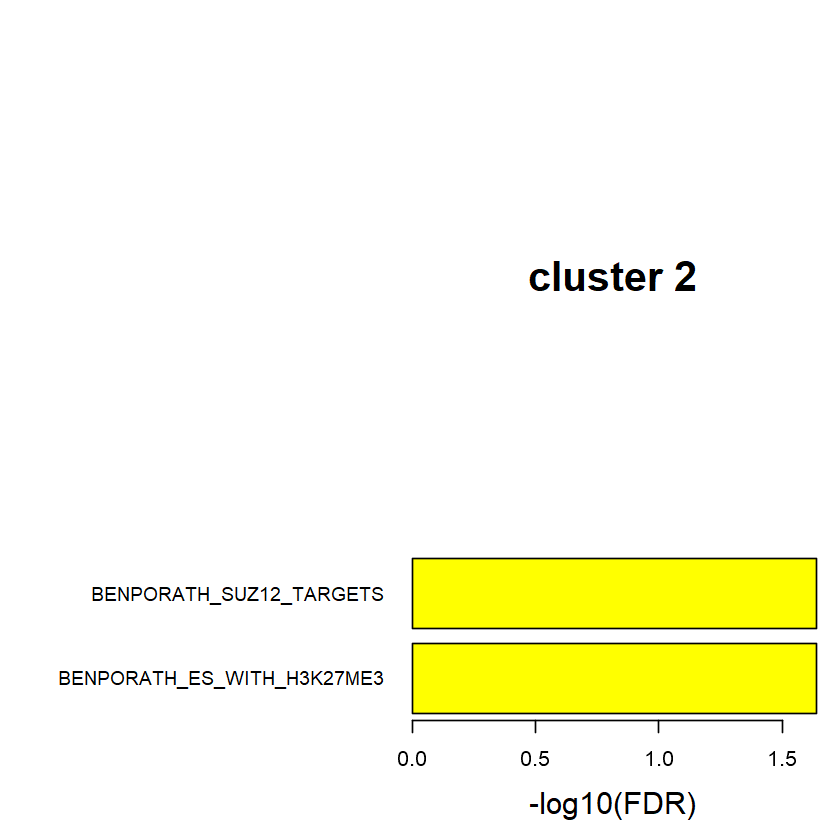

In [6]:
i=3
par(mar=c(5,17,23,1),fig=c(0,1,0,1))
barplot(-log10(unlist(Fgsea[i])),names=unlist(name[i]),col=colors[i],horiz = TRUE,las=1,xlab="-log10(FDR)",main=paste0("cluster ",as.character(i-1)),cex.names=0.92,cex.main=2,cex.lab=1.5)

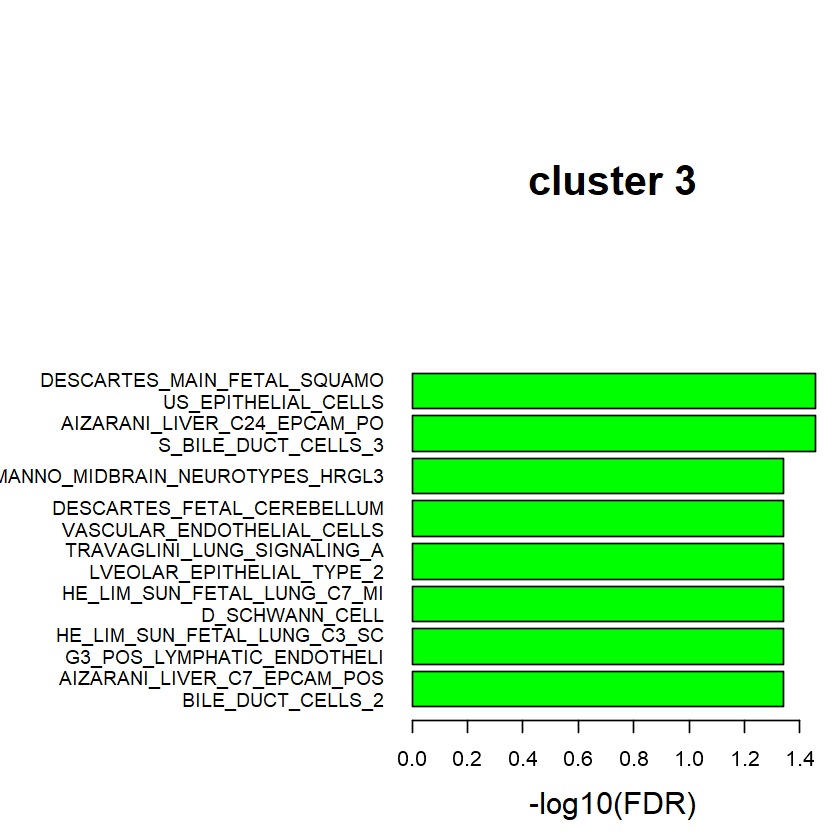

In [7]:
i=4
par(mar=c(5,17,15,1),fig=c(0,1,0,1))
barplot(-log10(unlist(Fgsea[i])),names=unlist(name[i]),col=colors[i],horiz = TRUE,las=1,xlab="-log10(FDR)",main=paste0("cluster ",as.character(i-1)),cex.names=0.92,cex.main=2,cex.lab=1.5)

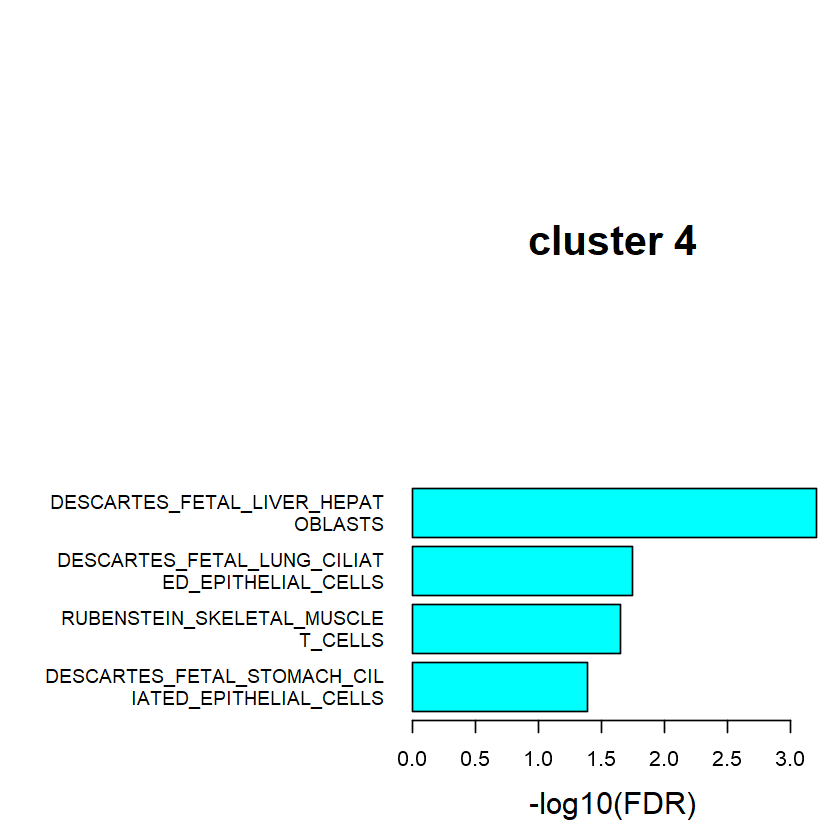

In [8]:
i=5
par(mar=c(5,17,20,1),fig=c(0,1,0,1))
barplot(-log10(unlist(Fgsea[i])),names=unlist(name[i]),col=colors[i],horiz = TRUE,las=1,xlab="-log10(FDR)",main=paste0("cluster ",as.character(i-1)),cex.names=0.92,cex.main=2,cex.lab=1.5)

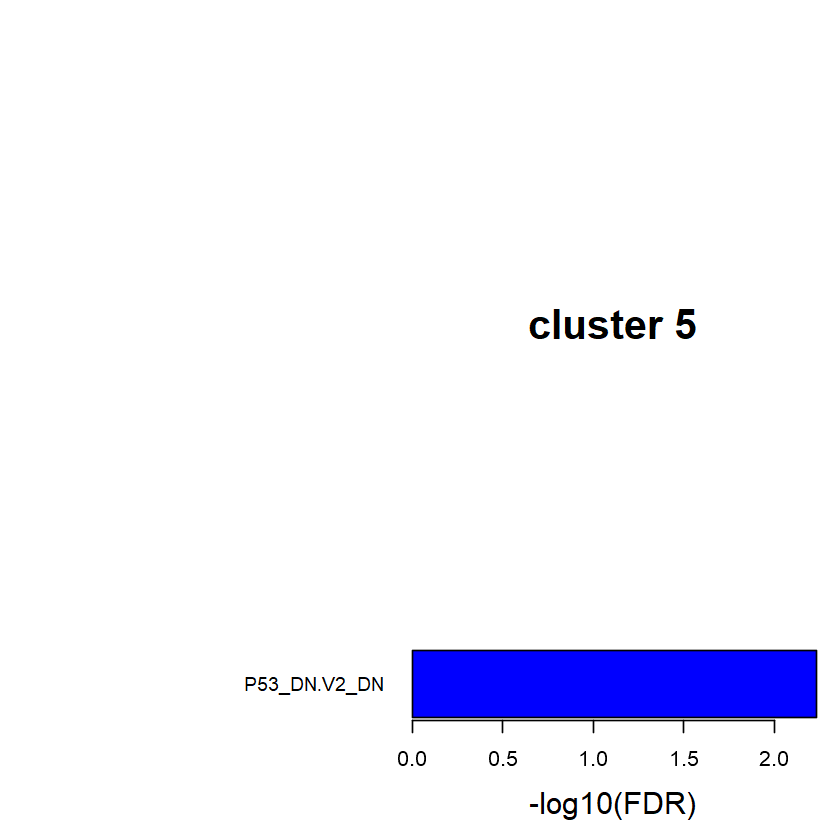

In [9]:
i=6
par(mar=c(5,17,27,1),fig=c(0,1,0,1))
barplot(-log10(unlist(Fgsea[i])),names=unlist(name[i]),col=colors[i],horiz = TRUE,las=1,xlab="-log10(FDR)",main=paste0("cluster ",as.character(i-1)),cex.names=0.92,cex.main=2,cex.lab=1.5)

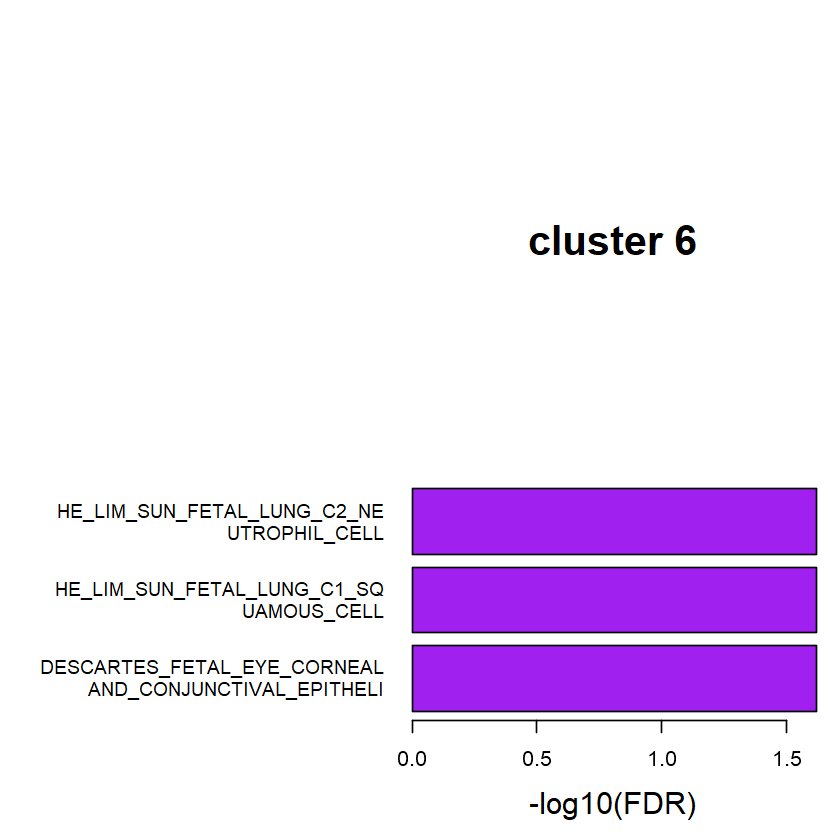

In [10]:
i=7
par(mar=c(5,17,20,1),fig=c(0,1,0,1))
barplot(-log10(unlist(Fgsea[i])),names=unlist(name[i]),col=colors[i],horiz = TRUE,las=1,xlab="-log10(FDR)",main=paste0("cluster ",as.character(i-1)),cex.names=0.92,cex.main=2,cex.lab=1.5)